<a href="https://colab.research.google.com/github/rb05751/PicarProject/blob/master/ObjectDetection/PiCar_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
!pip install beautifulsoup4
from bs4 import BeautifulSoup
!pip install tensorflow-gpu==2.1.0
import tensorflow as tf
print(tf.__version__)
! git clone https://github.com/rb05751/PicarProject.git

2.1.0
fatal: destination path 'PicarProject' already exists and is not an empty directory.


# Visualize Image with Bounding Box and Tag


(10, 28, 3)


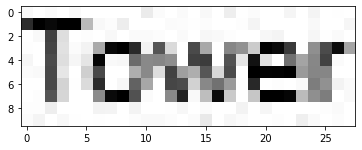

In [2]:
with open('/content/PicarProject/ObjectDetection/leaning tower of pisa - labels.xml', 'r') as f:
  data = f.read()

image = mpimg.imread('/content/PicarProject/ObjectDetection/leaning tower of pisa.jpeg')
tower_label = mpimg.imread('/content/PicarProject/ObjectDetection/Tower label.JPG')

soup = BeautifulSoup(data, "xml")
width = soup.find('width').get_text()
height = soup.find('height').get_text()
label = soup.find('name').get_text()
plt.imshow(tower_label[9:19, 11:39,:]); ##The tower is properly cropped to make sure not other whitespace is included.

It took 0.0008947849273681641 seconds to draw the box


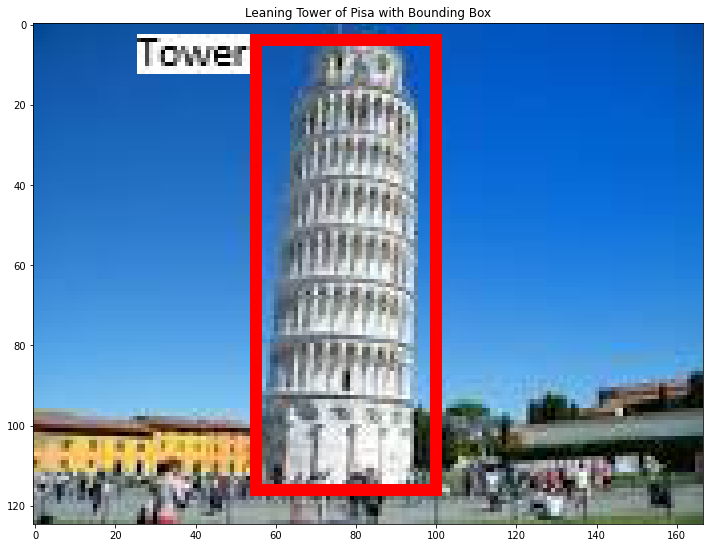

In [4]:
xmin = int(soup.find('xmin').get_text())
xmax = int(soup.find('xmax').get_text())
ymin = int(soup.find('ymin').get_text())
ymax = int(soup.find('ymax').get_text())

image = np.array(image)

def draw_box(image, xmin,xmax,ymin,ymax):
  for i in range(ymax-ymin):
    for j in range(3):
      if j == 0:
        image[ymin+i,xmin:xmin + 3, j] = 255
      else:
        image[ymin+i,xmin:xmin + 3, j] = 0

  for i in range(xmax-xmin):
    for j in range(3):
      if j == 0:
        image[ymin:ymin+3,xmin+i, j] = 255
      else:
        image[ymin:ymin+3,xmin+i, j] = 0

  for i in range(ymax-ymin):
    for j in range(3):
      if j == 0:
        image[ymin+i,xmax-3:xmax, j] = 255
      else:
        image[ymin+i,xmax-3:xmax, j] = 0

  for i in range(xmax-xmin):
    for j in range(3):
      if j == 0:
        image[ymax-3:ymax,xmin+i, j] = 255
      else:
        image[ymax-3:ymax,xmin+i, j] = 0

  return image


label = np.array(tower_label[9:19, 11:39,:])
import time
start = time.time()
image = draw_box(image, xmin, xmax, ymin, ymax)
print(f"It took {time.time()-start} seconds to draw the box")
image[ymin:ymin+10, xmin-28:xmin] = label

plt.figure(figsize= (12,10))
plt.title('Leaning Tower of Pisa with Bounding Box')
plt.imshow(image);

# Extract, Transform, and Load Images & Labels for Training

During the extraction stage, I could only extract a portion of the images due to the fact that I have limited RAM in my Google Colab. 

Image Augmentation was performed on the original ~ 400 images to produce a dataset that totaled close to 2000. Each image was resized to (320,320,3) for an optimal tradeoff between input size and not losing information to removing pixels. Off the PiCars camera they are (480,640,3) so shrinking the image to anything smaller than (320,320,3) posed an issue in practice with accuracy although it allowed for smaller model size.

The image augmentation consisted of resizing, flipping images, blurring images, and doing a flip and blur. On the flips, I had to create a function to swap the xmin and xmax labels to the other side of the image.

I had previous images from the steering angle prediction portion of this project that I loaded in to be the "nothing" labeled images. This is to help with with the model not having bias towards there being an object in the image.

In terms of labeling, each image has three groups of labels. <br>

1) The probability that an object is in an image (Pc) <br>
2) The Bounding Box Dimensions (bbdims) <br>
3) The Class Labels (e.g. Nothing, Stop, Go, 25mph, 55mph) <br>

The Bounding box dimensions were created using the LabelImg software and were stored in XML format, which is similar to HTML in that it is a markup langugage. Therefore in order to extract the dimensions of the bounding boxes, I had to use the BeautifulSoup package. 

The bounding boxes come in the form: [xmin, xmax, ymin, ymax]. <br>

Xmin is the left edge of the box <br>
Xmax is the right edge of the box <br>
ymin is the bottom edge of the box <br>
Ymax is the top edge of the box <br>

These will be used later to create the intersection over union metric to determine to what extent the models predictions overlap with the ground truth bounding box dimensions.

In [15]:
import random
import os

def img_preprocess(img):
  img = np.array(img, dtype = np.uint8)
  img = np.array(cv2.resize(img, (320,320))) / 255
  return img

def swapexes(xmin, xmax):
  temp = xmin
  xmin = xmax
  xmax = temp
  return xmin, xmax

def flip_and_label(image, xmin, xmax, ymin, ymax):
  image = np.array(tf.image.flip_left_right(image))
  xmin = 320 - xmin
  xmax = 320 - xmax
  xmin, xmax = swapexes(xmin, xmax)
  ymin = ymin
  ymax = ymax
  return image, xmin/320, xmax/320, ymin/320, ymax/320

def blur_image(image, label):
  image = cv2.blur(image, (9,9))
  return image, label


labels = []
images = []
no_obj_images = []
no_obj_labels = []
names = ['stop','go','25','55','toy']
indexes = list(range(697))
random.shuffle(indexes)
indexes = indexes[:int(len(indexes)*0.65)]


for i in indexes:
  try:
    with open(f'PicarProject/Code/ObjDetect/ObjectDetectionImage{str(i)}-label.xml', 'r') as f:
      data = f.read()
    image = mpimg.imread(f'PicarProject/Code/ObjDetect/ObjectDetectionImage{str(i)}.jpg')
    image = img_preprocess(image)
    images.append(image)

    ##Scrape label for Pc, bbdims, and classes
    soup = BeautifulSoup(data, "xml")
    obj = soup.find('object')
    n = obj.find('name').get_text()
    col_idx = names.index(n) #class label

    #bbdims
    xmin = int(obj.find('xmin').get_text()) // 2
    xmax = int(obj.find('xmax').get_text()) // 2
    ymin = int(obj.find('ymin').get_text()) // 1.5
    ymax = int(obj.find('ymax').get_text()) // 1.5
    l = [xmin/320,xmax/320,ymin/320,ymax/320]
    labels.append([1,l[0],l[1],l[2],l[3],col_idx+1])

    ##append the flipped image and label:
    flip_image, xmin, xmax, ymin, ymax = flip_and_label(image, xmin, xmax, ymin, ymax)
    images.append(flip_image)
    labels.append([1,xmin, xmax,ymin,ymax,col_idx+1])

    ##append the blurred image and label:
    blurry_image, label = blur_image(image, label = [1,l[0],l[1],l[2],l[3],col_idx+1])
    images.append(blurry_image)
    labels.append(label)

    ##append the flipped and blurred image:
    flip_and_blurry_image, label = blur_image(flip_image, label = [1,xmin, xmax,ymin,ymax,col_idx+1])
    images.append(flip_and_blurry_image)
    labels.append(label)
  except:
    continue


##Loading the No object images
im_no_obj = os.listdir('PicarProject/Code/Images/NewImages')
random_idx = np.random.randint(1,len(im_no_obj),len(images)//5)
for i in random_idx:
    try:
      image = mpimg.imread(f'PicarProject/Code/Images/NewImages/image{str(i)}.jpg')
      image = img_preprocess(image)
      no_obj_images.append(image)
      no_obj_labels.append([0,0,0,0,0,0])
    except:
      continue


images = np.reshape(images, (len(images), images[0].shape[0], images[0].shape[1], images[0].shape[2]))
labels = np.reshape(labels, (len(labels), len(labels[0])))
no_obj_images = np.reshape(no_obj_images, newshape = (len(no_obj_images), no_obj_images[0].shape[0], no_obj_images[0].shape[1], no_obj_images[0].shape[2]))
no_obj_labels = np.reshape(no_obj_labels, newshape = (len(no_obj_images),6))
print(f"Shape of Object Images Array: {images.shape}")
print(f"Shape of Object Label Array: {labels.shape}")
print(f"Shape of No Object Images Array: {no_obj_images.shape}")
print(f"Shape of No Object Images Array: {no_obj_labels.shape}")

Shape of Object Images Array: (1576, 320, 320, 3)
Shape of Object Label Array: (1576, 6)
Shape of No Object Images Array: (294, 320, 320, 3)
Shape of No Object Images Array: (294, 6)


# Merge The Object & No-Object Images and Create Labels for them

In [16]:
images = np.concatenate((images, no_obj_images),axis = 0)
labels = np.squeeze(np.concatenate((labels,no_obj_labels), axis = 0)) 

# Visualize Random Images From The Dataset

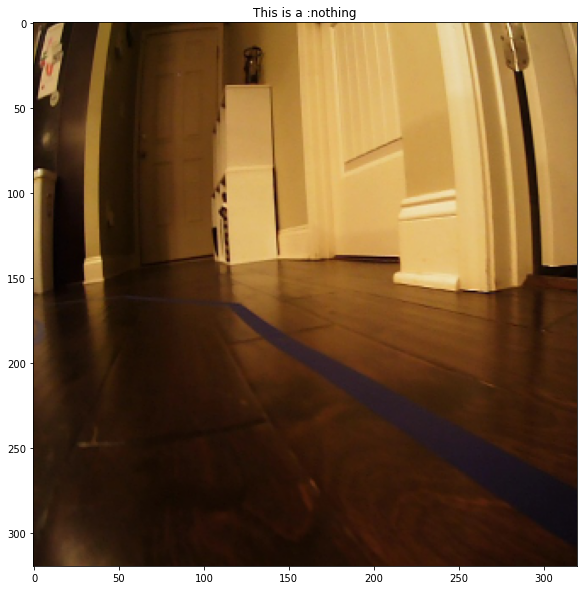

In [18]:
names.insert(0, 'nothing') ##TThis to insert the name "nothing into labels as it was not originally in the labels before concatenating images with labels
idx = np.random.randint(len(labels))

plt.figure(figsize = (12,10))
plt.title(f"This is a :{names[int(labels[idx,-1])]}")
plt.imshow(images[idx]);

# Visualize The Distribution of Data Per Label to Sanity Check for Class Imbalances

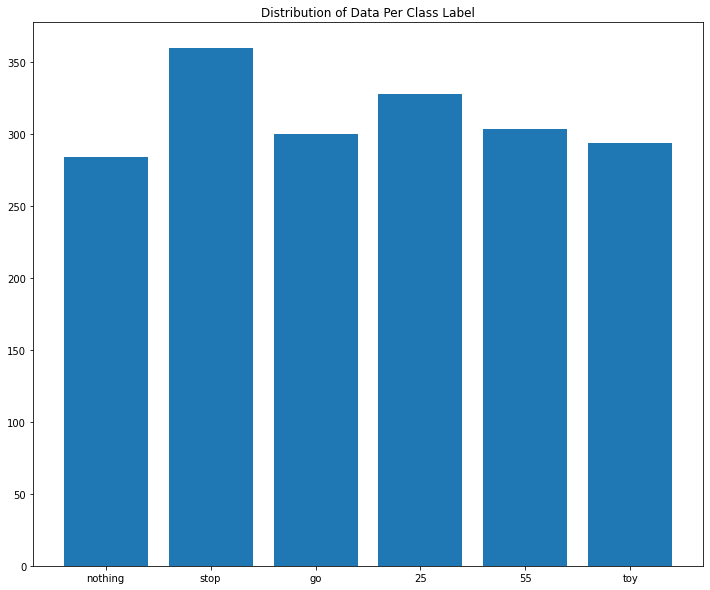

In [19]:
from collections import Counter

y = list(labels[:,-1])

class_counter = Counter()
class_counter.update(y)
class_counter


plt.figure(figsize = (12,10))
plt.title('Distribution of Data Per Class Label')
plt.bar(x = names,height = list(class_counter.values()));

# Visualize an Image with Bounding Box Label and Class Label

Note: We create a copy of the image prior to visualizing it for a specific reason. If we draw a bounding box on this image without copying it first it will change the image we have saved in memory for training. This will lead to data leakage on this one training example. This is not a huge issue when it is one image but could become an issue if we run this cell several times.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


113
These are the Bounding Box Dimensions for this image
Xmin: 133.0
Xmax: 178.0
Ymin: 118.0
Ymax: 203.0


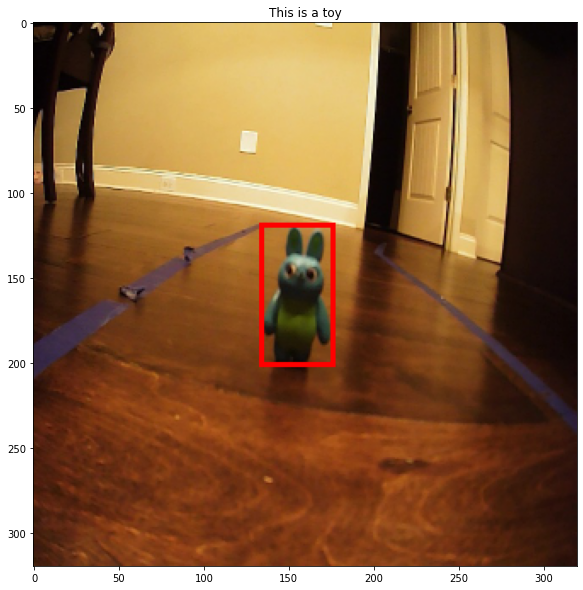

In [25]:
import copy

def extract_bbdims(idx):
  xmin, xmax, ymin, ymax = labels[idx][1]*320, labels[idx][2]*320, labels[idx][3]*320, labels[idx][4]*320
  return xmin, xmax, ymin, ymax


idx = np.random.randint(0, len(images))
print(idx)
image = copy.copy(images[idx])
xmin, xmax, ymin, ymax = extract_bbdims(idx)
img = draw_box(image, xmin = int(xmin),xmax = int(xmax),ymin = int(ymin),ymax = int(ymax))

print(f"These are the Bounding Box Dimensions for this image")
print(f"Xmin: {xmin}")
print(f"Xmax: {xmax}")
print(f"Ymin: {ymin}")
print(f"Ymax: {ymax}")
plt.figure(figsize = (12,10))
plt.title(f"This is a {names[int(labels[idx,-1])]}")
plt.imshow(img);

# Transforming class labels from integers [0,1,2,3,4,5] --> One-Hot Encoded Categorical Variables.

For some reason, when the labels are kept as integers and even if sparse categorical crossentropy is applied as a loss function, the training does not improve. However, by transforming them to categorical, this solves the problem.

In [27]:
classes = tf.keras.utils.to_categorical(y = np.array(labels[:,5]),  dtype='float32')
labels = np.concatenate((labels[:,:-1],classes), axis = 1)
print(f"New Shape of Labels : {labels.shape}")

New Shape of Labels : (1870, 11)


#Model Architecture

The final model that was chose was built using TF.keras Functional API and consists of 3 Convolutional blocks and 2 Residual Blocks, followed by 2 Fully Connected Blocks. This is the base model.

The output of the model has three heads. The first head is for predicting the probability that an object is the image, the second is a regression ouput for predicting a 4D vector that represents the bounding box dimensions, and the third is a softmax output for class prediction probabilities (nothing, stop, go, 25, etc.)

In [28]:
input = tf.keras.layers.Input(shape = (320,320,3))

def residual_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    return x + inputs

def conv_block(inputs, filters, pool_size):
    x = tf.keras.layers.Conv2D(filters = filters, kernel_size=3, activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size = (pool_size,pool_size))(x)
    return x

def FCCBlock(inputs, nodes):
    x = tf.keras.layers.Dropout(rate = 0.3)(inputs)
    x = tf.keras.layers.Dense(nodes, activation = 'sigmoid')(x)
    return x


def base_model(input):
  x = conv_block(inputs = input, filters = 64, pool_size = 3)
  x = residual_block(x, filters = 64)
  x = conv_block(x, filters = 128, pool_size = 5)
  x = residual_block(x, filters = 128)
  x = conv_block(inputs = x, filters = 256, pool_size = 5)
  x = tf.keras.layers.Flatten()(x)
  x = FCCBlock(x, nodes = 256)
  x = FCCBlock(x, nodes = 128)
  return x

x = base_model(input)
output_1 = tf.keras.layers.Dense(1, name = 'pc', activation = 'sigmoid')(x)
output_2 = tf.keras.layers.Dense(4, name = 'bbdims', activation = 'sigmoid')(x)
output_3 = tf.keras.layers.Dense(6, name = 'classes', activation = 'softmax')(x)

model = tf.keras.Model(inputs = input, outputs = [output_1, output_2, output_3])
model.summary()
input = tf.random.normal(shape = (1,320,320,3))
pred = model(input)
print(f"Pc: {pred[0][0]}")
print(f"BBDims: {pred[1][0]}")
print(f"Classes: {pred[2][0]}")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 318, 318, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 318, 318, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 106, 106, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

##Model Training 

The training dataset was split 80/10/10 for train/valid/test. Due to RAM limitations in Google Colab free version, I had to to take a random sample from the entire dataset initially at the start of this notebook. This cell randomly shuffles that datasets and then breaks it up into train, valid, and test sets.

In [30]:
import random

def build_data():
  idx = list(range(images.shape[0]))
  random.shuffle(idx)
  train_pct = 0.8
  train_images = images[idx[:int(len(idx)*0.8)]]
  train_labels = labels[idx[:int(len(idx)*0.8)]]
  train_y = (np.array(train_labels[:,0]), np.array(train_labels[:,1:5]), np.array(train_labels[:,5:]).astype(int))

  valid_images = images[idx[int(len(idx)*0.8):int(len(idx)*0.9)]]
  valid_labels = labels[idx[int(len(idx)*0.8):int(len(idx)*0.9)]]
  valid_y = (np.array(valid_labels[:,0]), np.array(valid_labels[:,1:5]), np.array(valid_labels[:,5:]))

  test_images = images[idx[int(len(idx)*0.9):]]
  test_labels = labels[idx[int(len(idx)*0.9):]]
  test_y = (np.array(test_labels[:,0]), np.array(test_labels[:,1:5]), np.array(test_labels[:,5:]))

  return train_images, train_y, valid_images, valid_y, test_images, test_y

train_images, train_y, valid_images, valid_y, test_images, test_y = build_data()

print(train_images.shape)
print(train_y[0].shape)
print(valid_images.shape)
print(test_images.shape)
print(test_y[0].shape)

(1496, 320, 320, 3)
(1496,)
(187, 320, 320, 3)
(187, 320, 320, 3)
(187,)


In [31]:
y_true = [1,4,1,5]
y_pred = [1,4,5,6]

def area(box_dims):
  xmin, xmax, ymin, ymax = box_dims[0], box_dims[1], box_dims[2], box_dims[3]
  return (ymax - ymin) * (xmax - xmin)

def overlap(y_true, y_pred):
  xmin_pred, xmax_pred, ymin_pred, ymax_pred = y_pred[0], y_pred[1], y_pred[2], y_pred[3]
  xmin_true, xmax_true, ymin_true, ymax_true = y_true[0], y_true[1], y_true[2], y_true[3]
  if (((xmin_pred >= xmax_true) or (xmax_pred <= xmin_true)) or ((ymin_pred >= ymax_true) or (ymax_pred <= ymin_true))):
    return False
  else:
    return True

def calc_intersect(y_true,y_pred):
  xmin_pred, xmax_pred, ymin_pred, ymax_pred = y_pred[0], y_pred[1], y_pred[2], y_pred[3]
  xmin_true, xmax_true, ymin_true, ymax_true = y_true[0], y_true[1], y_true[2], y_true[3]
  height = min(ymax_pred, ymax_true) - max(ymin_pred, ymin_true)
  length = min(xmax_pred, xmax_true) - max(xmin_pred, xmin_true)
  return length * height

def IOU(y_true, y_pred):
  if overlap(y_true,y_pred):
    intersection = calc_intersect(y_true, y_pred)
    union = (area(y_true) + area(y_pred)) - intersection
    return intersection / union
  else:
    return 0

print(IOU(y_true,y_pred))

def MeanCube(y_true, y_pred):
  return tf.reduce_mean((abs(tf.subtract(y_true,y_pred)))**3)


def MegaCategoricalLoss(y_true,y_pred):
  loss = 2 *  tf.square(tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0))
  return loss

0


##Training Continued

Since the model has three heads as output that means there needs to be three seperate loss functions and three seperate accuracy metrics. The coefficients for the loss functions are defined in the model.compile method. 

The coefficients are higher on the bbdims and classes because not only are these the most important in terms of detection and decision making based off that detection but they were the heads that struggled the most during previous training. Empirically, these have shown to be the optimal coefficients across the board.

There is a learning rate decay function applied below that helps for stabilizing the loss as the epochs increase.

In [32]:
#Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer,
              loss={'pc':'binary_crossentropy','bbdims': 'mse', 'classes': 'categorical_crossentropy'},
              metrics={'pc':'accuracy',
                       'bbdims': 'mae',
                       'classes': 'categorical_crossentropy'},
              loss_weights = {'pc': 0.1, 'bbdims':1.5, 'classes':2.0}
              )

In [33]:
#Train the model for 500 epochs
def lr_decay(epoch):
  init_lr = 1e-3
  lr = init_lr * (.1 * 30/(epoch+1))
  return lr

history = model.fit(train_images, train_y,
                    epochs=50, batch_size=16, shuffle = True, validation_data=(valid_images, valid_y), callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_decay,verbose=1),tf.keras.callbacks.EarlyStopping(patience=100,min_delta=0.05,mode='min',monitor='val_classes_loss',restore_best_weights=True,verbose=1)])

Train on 1496 samples, validate on 187 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.003.
Epoch 1/50
1496/1496 [==============================] - 23s 15ms/sample - loss: 3.1590 - pc_loss: 0.3221 - bbdims_loss: 0.0485 - classes_loss: 1.5248 - pc_accuracy: 0.8770 - bbdims_mae: 0.1727 - classes_categorical_crossentropy: 1.5269 - val_loss: 10.4537 - val_pc_loss: 1.6716 - val_bbdims_loss: 0.1617 - val_classes_loss: 5.0189 - val_pc_accuracy: 0.1444 - val_bbdims_mae: 0.3337 - val_classes_categorical_crossentropy: 5.0216

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0015.
Epoch 2/50
1496/1496 [==============================] - 18s 12ms/sample - loss: 2.1837 - pc_loss: 0.1253 - bbdims_loss: 0.0362 - classes_loss: 1.0582 - pc_accuracy: 0.9699 - bbdims_mae: 0.1466 - classes_categorical_crossentropy: 1.0584 - val_loss: 10.8379 - val_pc_loss: 2.1336 - val_bbdims_loss: 0.1656 - val_classes_loss: 5.1852 - val_pc_accuracy: 0.1444 - val_bbdims_mae: 0.3381 - v

187/187 [==============================] - 1s 4ms/sample - loss: 0.0551 - pc_loss: 0.0015 - bbdims_loss: 0.0083 - classes_loss: 0.0209 - pc_accuracy: 1.0000 - bbdims_mae: 0.0637 - classes_categorical_crossentropy: 0.0212
Models accuracy on the test set: [0.05507963017266702, 0.0015128129, 0.008294118, 0.020881832, 1.0, 0.06369009, 0.021213755]


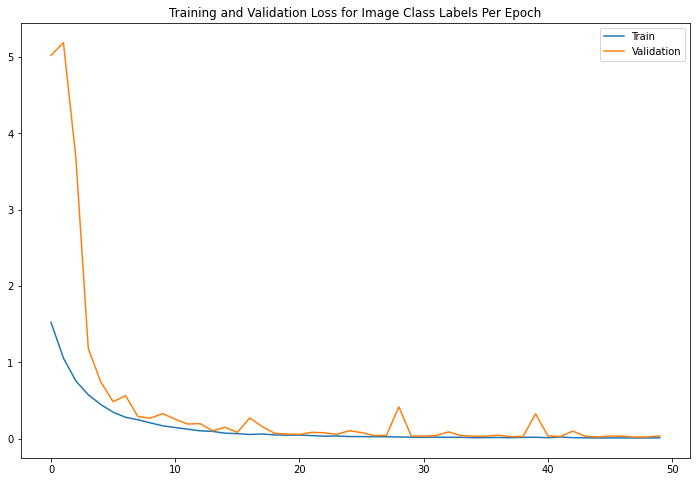

In [39]:
print(f"Models accuracy on the test set: {model.evaluate(test_images, test_y)}")
plt.figure(figsize = (12,8))
plt.title('Training and Validation Loss for Image Class Labels Per Epoch')
plt.plot(history.history['classes_loss'])
plt.plot(history.history['val_classes_loss']);
plt.legend(('Train','Validation'));

# Visualize Predictions on the Validation Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of an Object (Prediction): [[0.99893576]]
Ground Truth: 1.0

Bounding Box Dims: [[0.45568642 0.5999121  0.21805352 0.64040047]]
Ground Truth Dims: [0.459375 0.565625 0.26875  0.571875]

Class Predictions: [[2.2998110e-04 2.7593194e-05 6.4259005e-04 3.4341647e-03 9.9485070e-01
  8.1498036e-04]]
Ground Truth Classes : [0. 0. 0. 0. 1. 0.]
IOU metric: 0.5287358164787292



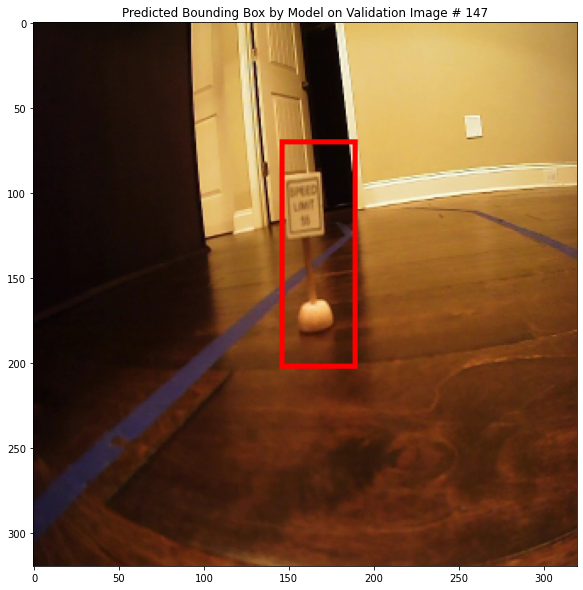

In [49]:
num = np.random.randint(0,valid_y[0].shape[0])
image = copy.copy(valid_images[num])
pred = model(np.expand_dims(image, axis = 0).astype(np.float32))
image = draw_box(image, xmin = int(float(pred[1][:,0])*320),xmax = int(float(pred[1][:,1]*320)),ymin = int(float(pred[1][:,2]*320)),ymax = int(float(pred[1][:,3]*320 )))
print(f"Probability of an Object (Prediction): {pred[0]}")
print(f"Ground Truth: {valid_y[0][num]}")
print()
print(f"Bounding Box Dims: {pred[1]}")
print(f"Ground Truth Dims: {valid_y[1][num]}")
print()
print(f"Class Predictions: {pred[2]}")
print(f"Ground Truth Classes : {valid_y[2][num]}")
print(f"IOU metric: {IOU(y_true = valid_y[1][num], y_pred = pred[1][0])}")
print()

plt.figure(figsize= (12,10))
plt.title(f'Predicted Bounding Box by Model on Validation Image # {num}')
plt.imshow(image);

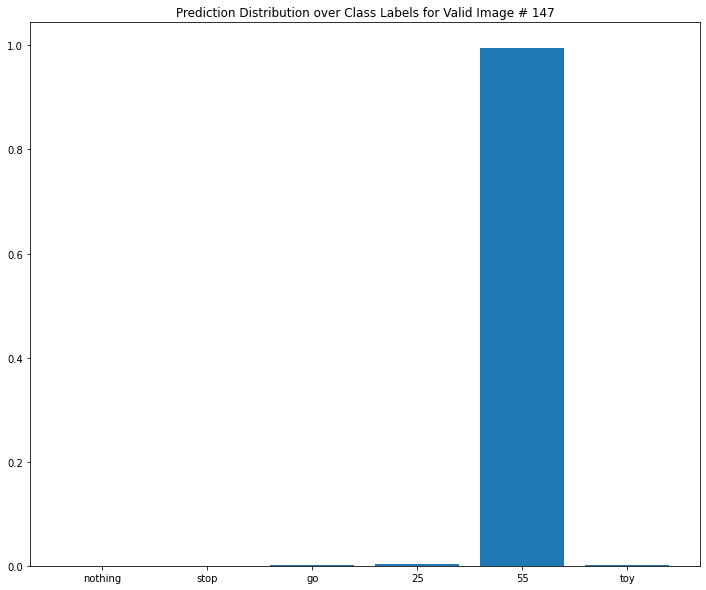

In [50]:
names = ['nothing','stop','go','25','55','toy']
height = list(np.array(pred[2]))[0]


 ##This the distribution of class label scores
plt.figure(figsize = (12,10))
plt.title(f'Prediction Distribution over Class Labels for Valid Image # {num}')
plt.bar(x = names, height = height);

# Visualizing Model Predictions on Test Data

In [51]:
model.save('/content/PicarProject/tf_model_0213_obj_local.h5')

In [52]:
saved_model = tf.keras.models.load_model('/content/PicarProject/tf_model_0213_obj_local.h5')

In [53]:
saved_model.compile(optimizer=optimizer,
              loss={'pc':'binary_crossentropy','bbdims': MeanCube, 'classes': MegaCategoricalLoss},
              metrics={'pc':'accuracy',
                       'bbdims': 'mae',
                       'classes': 'categorical_crossentropy'},
              loss_weights = {'pc': 0.1, 'bbdims':0.35, 'classes':0.55}
              )
print(f"Models accuracy on the test set: {saved_model.evaluate(test_images, test_y)}")

187/187 [==============================] - 1s 6ms/sample - loss: 0.0205 - pc_loss: 0.0015 - bbdims_loss: 0.0018 - classes_loss: 0.0350 - pc_accuracy: 1.0000 - bbdims_mae: 0.0637 - classes_categorical_crossentropy: 0.0212
Models accuracy on the test set: [0.020526226891334202, 0.0015128129, 0.0017518721, 0.035006795, 1.0, 0.06369009, 0.021213755]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability of an Object (Prediction): [[0.998005]]
Ground Truth: 1.0

Predicted Bounding Box Dims: [[0.2072948  0.34006858 0.20335819 0.6402775 ]]
Ground Truth Dims: [0.240625 0.425    0.165625 0.759375]

Class Predictions: [[6.6936738e-04 4.5701363e-05 7.9149933e-04 1.3885273e-02 9.8347074e-01
  1.1374537e-03]]
Ground Truth Classes : [0. 0. 0. 0. 1. 0.]
IOU metric: 0.3502941429615021



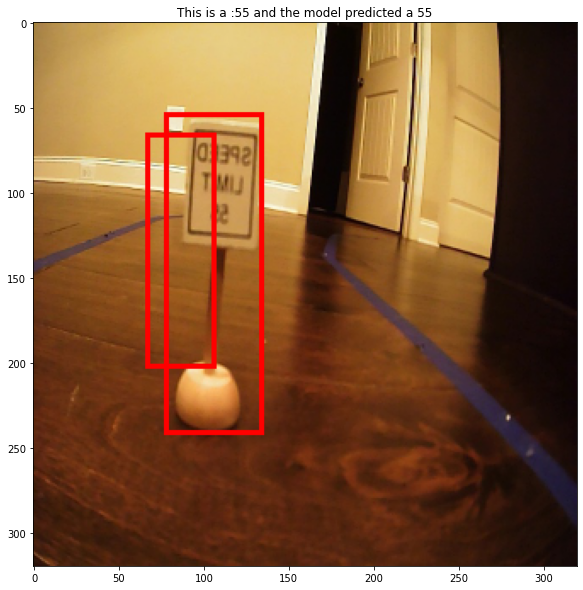

In [62]:
num = np.random.randint(0,test_images.shape[0])
image = copy.copy(test_images[num])
pred = saved_model(np.expand_dims(image, axis = 0).astype(np.float32))


print(f"Probability of an Object (Prediction): {pred[0]}")
print(f"Ground Truth: {test_y[0][num]}")
print()
print(f"Predicted Bounding Box Dims: {pred[1]}")
print(f"Ground Truth Dims: {test_y[1][num]}")
print()
print(f"Class Predictions: {pred[2]}")
print(f"Ground Truth Classes : {test_y[2][num]}")
print(f"IOU metric: {IOU(y_true = test_y[1][num], y_pred = pred[1][0])}")
image = draw_box(image, xmin = int(float(pred[1][:,0])*320),xmax = int(float(pred[1][:,1]*320)),ymin = int(float(pred[1][:,2]*320)),ymax = int(float(pred[1][:,3]*320 )))
image = draw_box(image, xmin = int(float(test_y[1][num][0])*320),xmax = int(float(test_y[1][num][1]*320)),ymin = int(float(test_y[1][num][2]*320)),ymax = int(float(test_y[1][num][3]*320 )))

print()
plt.figure(figsize = (12,10))
plt.title(f"This is a :{names[np.argmax(test_y[2][num])]} and the model predicted a {names[np.argmax(pred[2][0])]}")
plt.imshow(image);

<BarContainer object of 6 artists>

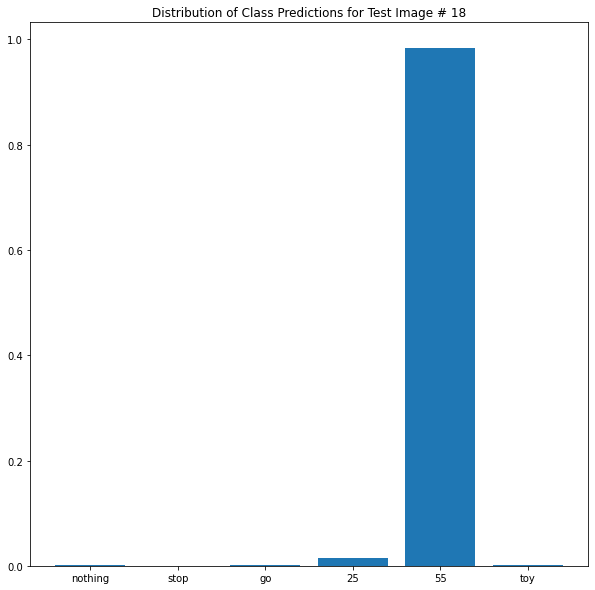

In [63]:
names = ['nothing','stop','go','25','55','toy']
height = list(np.array(pred[2]))[0]

plt.figure(figsize = (10,10))
plt.title(f'Distribution of Class Predictions for Test Image # {num}')
plt.bar(x = names, height = height)